In [2]:
import pickle
import numpy as np
import pandas as pd
result = pickle.load(open("results/fold1_result", "rb"))

In [3]:
print(result[8])

[0, 15387, 3569, 1980, 1386, 1024, 857, 696, 628, 555, 484, 420, 341, 356, 335, 300, 249, 224, 238, 207, 221, 194, 200, 160, 155, 163, 132, 139, 145, 150, 119, 124, 114, 137, 105, 106, 90, 69, 93, 88, 67, 89, 63, 74, 67, 70, 48, 71, 76, 70, 65, 67, 65, 64, 69, 45, 49, 54, 48, 49, 48, 47, 49, 42, 50, 35, 44, 42, 44, 43, 43, 33, 34, 41, 36, 35, 42, 36, 33, 35, 36, 33, 31, 29, 30, 38, 29, 41, 32, 33, 34, 32, 29, 20, 30, 31, 26, 25, 21, 30, 29]


In [4]:
s = 0
for i in result[8]:
    s += i
print(s)
print(s/58077)

34661
0.5968111300514833


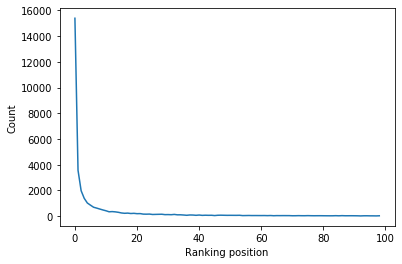

In [6]:
import matplotlib.pyplot as plt

plt.plot(result[8][1:100])
plt.xlabel('Ranking position')
plt.ylabel('Count')
plt.savefig('fig1.eps', format='eps')
plt.show()
# eixo x -> posição rank
# eixo y -> qtd classificações nessa posição 

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import check_array, check_X_y, check_is_fitted
from sklearn.utils.sparsefuncs import csc_median_axis_0
from sklearn.utils.multiclass import check_classification_targets

n_split = 1
check_point_predicts_len = 100

class NearestCentroid(BaseEstimator, ClassifierMixin):

    def __init__(self, metric='euclidean', shrink_threshold=None):
        self.metric = metric
        self.shrink_threshold = shrink_threshold

    def fit(self, X, y):

        if self.metric == 'precomputed':
            raise ValueError("Precomputed is not supported.")
        # If X is sparse and the metric is "manhattan", store it in a csc
        # format is easier to calculate the median.
        if self.metric == 'manhattan':
            X, y = check_X_y(X, y, ['csc'])
        else:
            X, y = check_X_y(X, y, ['csr', 'csc'])
        is_X_sparse = sp.issparse(X)
        if is_X_sparse and self.shrink_threshold:
            raise ValueError("threshold shrinking not supported"
                             " for sparse input")
        check_classification_targets(y)

        n_samples, n_features = X.shape
        le = LabelEncoder()
        y_ind = le.fit_transform(y)
        self.classes_ = classes = le.classes_
        n_classes = classes.size
        if n_classes < 2:
            raise ValueError('The number of classes has to be greater than'
                             ' one; got %d class' % (n_classes))

        # Mask mapping each class to its members.
        self.centroids_ = sp.lil_matrix((n_classes, n_features), dtype=np.float64)
        # Number of clusters in each class.
        nk = np.zeros(n_classes)

        for cur_class in range(n_classes):
            center_mask = y_ind == cur_class
            nk[cur_class] = np.sum(center_mask)
            if is_X_sparse:
                center_mask = np.where(center_mask)[0]

            # XXX: Update other averaging methods according to the metrics.
            if self.metric == "manhattan":
                # NumPy does not calculate median of sparse matrices.
                if not is_X_sparse:
                    self.centroids_[cur_class] = np.median(X[center_mask], axis=0)
                else:
                    self.centroids_[cur_class] = csc_median_axis_0(X[center_mask])
            else:
                if self.metric != 'euclidean':
                    warnings.warn("Averaging for metrics other than "
                                  "euclidean and manhattan not supported. "
                                  "The average is set to be the mean."
                                  )
                self.centroids_[cur_class] = X[center_mask].mean(axis=0)

        if self.shrink_threshold:
            dataset_centroid_ = np.mean(X, axis=0)

            # m parameter for determining deviation
            m = np.sqrt((1. / nk) - (1. / n_samples))
            # Calculate deviation using the standard deviation of centroids.
            variance = (X - self.centroids_[y_ind]) ** 2
            variance = variance.sum(axis=0)
            s = np.sqrt(variance / (n_samples - n_classes))
            s += np.median(s)  # To deter outliers from affecting the results.
            mm = m.reshape(len(m), 1)  # Reshape to allow broadcasting.
            ms = mm * s
            deviation = ((self.centroids_ - dataset_centroid_) / ms)
            # Soft thresholding: if the deviation crosses 0 during shrinking,
            # it becomes zero.
            signs = np.sign(deviation)
            deviation = (np.abs(deviation) - self.shrink_threshold)
            np.clip(deviation, 0, None, out=deviation)
            deviation *= signs
            # Now adjust the centroids using the deviation
            msd = ms * deviation
            self.centroids_ = dataset_centroid_[np.newaxis, :] + msd
        return self

    def predict(self, X):

        check_is_fitted(self, 'centroids_')

        X = check_array(X, accept_sparse='csr')
        
        return np.argsort(pairwise_distances(X, self.centroids_, metric=self.metric))[:10]


In [33]:
vectorizer = pickle.load(open("vectorizer.pickle", "rb"))

for ii in range(1, 11):
    clf = pickle.load(open('split'+str(ii)+'_clf', 'rb'))
    X_test = vectorizer.transform(['Organização e armazenamento de conteúdo instrucional no ambiente AdaptWeb utilizando XML'])
    y_test = [430902, 422050]
    out = clf.predict(X_test)
    print('Ranking split '+str(ii)+':')
    for i in range(0,50):
        if clf.classes_[out[0][i]] in y_test:
#             print(str(i)+': '+str(clf.classes_[out[0][i]])+' <---')
        else:
            print(str(i)+': '+str(clf.classes_[out[0][i]]))
    print('---')

Ranking split 1:
0: 455871
1: 426613
2: 399864
3: 423400
4: 415703
5: 422050 <---
6: 459950
7: 461892
8: 444601
9: 401798
10: 429985
11: 436984
12: 433321
13: 437011
14: 446881
15: 461974
16: 433922
17: 415314
18: 440310
19: 412151
20: 420442
21: 423374
22: 405175
23: 448979
24: 436370
25: 420079
26: 432373
27: 431301
28: 430902 <---
29: 420039
30: 449047
31: 437229
32: 458640
33: 418363
34: 399391
35: 412291
36: 457130
37: 407996
38: 438077
39: 448208
40: 456462
41: 427118
42: 433521
43: 431872
44: 428838
45: 462488
46: 417796
47: 428191
48: 424588
49: 452113
---
Ranking split 2:
0: 426613
1: 455871
2: 423400
3: 422050 <---
4: 399864
5: 459950
6: 415703
7: 461892
8: 444601
9: 437011
10: 436984
11: 401798
12: 431301
13: 448979
14: 433321
15: 440310
16: 458640
17: 432373
18: 431872
19: 436370
20: 420442
21: 433922
22: 405175
23: 418363
24: 459602
25: 429427
26: 400906
27: 423374
28: 415314
29: 417796
30: 437229
31: 462488
32: 433344
33: 449047
34: 412151
35: 461974
36: 448192
37: 420079

In [6]:
# vectorizer = pickle.load(open("vectorizer.pickle", "rb"))

# for ii in range(1, 11):
#     clf = pickle.load(open('split'+str(ii)+'_clf', 'rb'))
#     X_test = vectorizer.transform(['Revisão, filogenia e biogeografia de espécies Neotropicais de Paralucilia (Diptera, Calliphoridae)'])
#     out = clf.predict(X_test)
#     print('Ranking split '+str(ii)+':')
#     for i in range(0,50):
#         print(str(i)+': '+str(clf.classes_[out[0][i]]))
#     print('---')

Ranking split 1:
0: 423208
1: 460809
2: 407550
3: 440538
4: 441619
5: 400733
6: 416708
7: 429485
8: 453244
9: 444312
10: 462027
11: 450711
12: 408200
13: 460656
14: 449429
15: 402581
16: 452746
17: 422266
18: 405505
19: 444638
20: 408405
21: 415291
22: 414363
23: 416789
24: 436984
25: 447699
26: 423538
27: 420547
28: 401798
29: 408810
30: 457404
31: 452010
32: 420079
33: 433321
34: 406713
35: 425578
36: 412742
37: 451823
38: 428838
39: 420442
40: 459950
41: 456110
42: 449047
43: 434745
44: 423374
45: 407546
46: 406324
47: 399974
48: 419403
49: 427118
---
Ranking split 2:
0: 434745
1: 460809
2: 441619
3: 423208
4: 407550
5: 429485
6: 400733
7: 416708
8: 440538
9: 462027
10: 444312
11: 453244
12: 405505
13: 406713
14: 408200
15: 450711
16: 460656
17: 449429
18: 456110
19: 416789
20: 452746
21: 422266
22: 444638
23: 408405
24: 436984
25: 423538
26: 425578
27: 412742
28: 402581
29: 401798
30: 433321
31: 459440
32: 420079
33: 452010
34: 459950
35: 408810
36: 417781
37: 428838
38: 419403
39:

In [13]:
print("Scores:")
sum = 0
for i in range(1,11):
    result = pickle.load(open("results/fold"+str(i)+"_result", "rb"))
    print("Fold "+str(i)+": "+str(round(result[3], 4)))
    sum += result[3]
print("Mean: "+str(round(sum/10,4)))

Scores:
Fold 1: 0.3259
Fold 2: 0.3266
Fold 3: 0.3216
Fold 4: 0.3236
Fold 5: 0.3239
Fold 6: 0.3245
Fold 7: 0.3256
Fold 8: 0.3223
Fold 9: 0.3242
Fold 10: 0.3228
Mean: 0.3241
